In [1]:
%load_ext autoreload
%autoreload 2
%load_ext lab_black

In [30]:
from pyspark.sql import functions as F
from manga_recsys.spark import get_spark
import matplotlib.pyplot as plt
import numpy as np

spark = get_spark()
df = spark.read.parquet("../data/processed/2022-12-10-mangadex-manga/")

In [5]:
attributes = df.select("attributes.*")
attributes.show(vertical=True, n=1, truncate=60)

-RECORD 0--------------------------------------------------------------------------------------
 availableTranslatedLanguages   | [en]                                                         
 chapterNumbersResetOnNewVolume | false                                                        
 contentRating                  | safe                                                         
 createdAt                      | 2021-03-12T22:52:05+00:00                                    
 isLocked                       | false                                                        
 lastChapter                    | null                                                         
 lastVolume                     | null                                                         
 latestUploadedChapter          | 8b366aa0-4179-4b98-a44d-3b6a810e5759                         
 originalLanguage               | ja                                                           
 publicationDemographic         | josei 

In [27]:
version_counts = attributes.groupBy("version").count().sort(F.desc("count")).toPandas()
version_counts

,version,count
0,2,25288
1,3,13449
2,4,7093
3,1,5866
4,5,4171
...,...,...
84,243,1
85,139,1
86,79,1
87,94,1


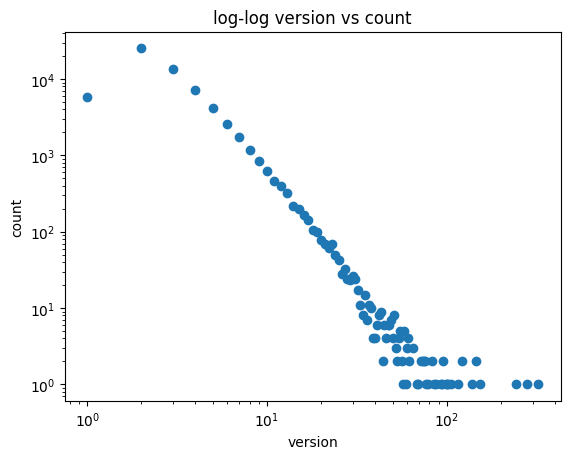

In [39]:
version_counts = version_counts.sort_values("version")
plt.plot(version_counts.version, version_counts["count"], "o")
plt.xlabel("version")
plt.ylabel("count")
plt.xscale("log")
plt.yscale("log")
plt.title("log-log version vs count")
plt.show()

In [22]:
# parse the created at date for the date part
created_dates = (
    attributes.select(F.col("createdAt").cast("date").alias("createdAt"))
    .groupBy("createdAt")
    .count()
)
created_dates.sort(F.asc("createdAt")).show(n=10)
created_dates.sort(F.desc("count")).show(n=10)

+----------+-----+
| createdAt|count|
+----------+-----+
|2018-01-18|   46|
|2018-01-19|   45|
|2018-01-20|   46|
|2018-01-21|   45|
|2018-01-22|   46|
|2018-01-23|   45|
|2018-01-24|   46|
|2018-01-25|   45|
|2018-01-26|   46|
|2018-01-27|   45|
+----------+-----+
only showing top 10 rows

+----------+-----+
| createdAt|count|
+----------+-----+
|2021-10-10|  509|
|2021-10-11|  165|
|2021-10-23|  122|
|2022-11-17|  109|
|2022-12-08|  104|
|2022-10-21|  102|
|2022-09-24|   94|
|2021-10-12|   87|
|2022-11-18|   76|
|2022-12-07|   75|
+----------+-----+
only showing top 10 rows



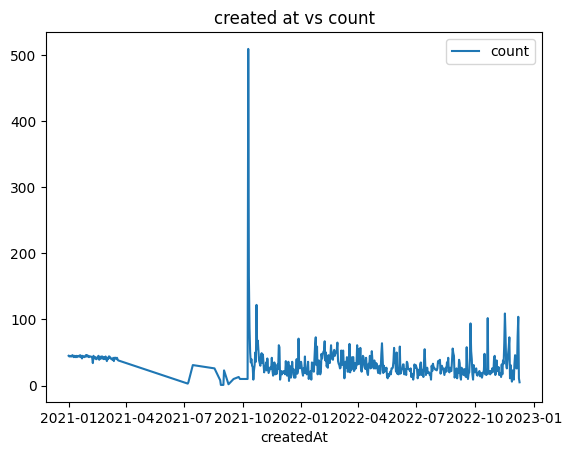

In [46]:
created_dates.where("createdAt >= '2021'").toPandas().plot(
    x="createdAt", y="count", kind="line"
)
plt.title("created at vs count")
plt.show()

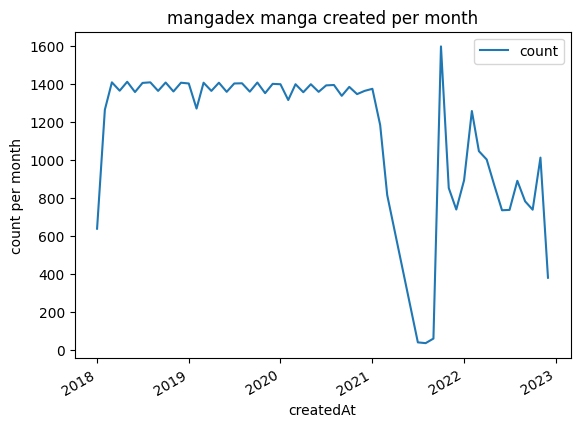

In [52]:
# group created dates by month
(
    attributes.groupBy(
        F.date_trunc("month", F.col("createdAt").cast("date")).alias("createdAt")
    )
    .count()
    .sort(F.asc("createdAt"))
    .toPandas()
    .plot(x="createdAt", y="count", kind="line")
)
plt.title("mangadex manga created per month")
plt.ylabel("count per month")
plt.show()

In [53]:
subset = attributes.select(F.col("createdAt").cast("date"), "version")
subset.count(), subset.where("version < 5 and createdAt < '2021-06-01'").count()

(65736, 43804)

In [54]:
subset = attributes.select(F.col("createdAt").cast("date"), "version")
subset.count(), subset.where("version = 1 and createdAt < '2021-06-01'").count()

(65736, 5863)